In [1]:
import glob
import operator
import tifffile
import numpy as np
import pandas as pd

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mibi_code_dir = '/Users/mschachter/code/mibi_processing'
import sys
sys.path.append(mibi_code_dir)
from mibi.preprocess.mibi_image import *
from mibi.preprocess.mibi_plot import *

In [3]:
data_dir = '/Users/mschachter/data/Immune_CIMAC_EDTA'
images_dir = os.path.join(data_dir, 'extracted')
out_dir = os.path.join(data_dir, 'images')
channels_data_path = os.path.join(data_dir, 'info', 'panel.csv')
df_channel = pd.read_csv(channels_data_path)

In [4]:
fovs = [f"Point{k}" for k in [1, 3, 5, 7, 9]]
mp_images = dict()
for fov in fovs:
    pdir = os.path.join(images_dir, fov)
    print(f"Loading from {pdir}")
    mp_images[fov] = MIBIMultiplexImage.load_from_path(os.path.join(pdir, 'TIFs'), channels_data_path)

Loading from /Users/mschachter/data/Immune_CIMAC_EDTA/extracted/Point1
Loading from /Users/mschachter/data/Immune_CIMAC_EDTA/extracted/Point3
Loading from /Users/mschachter/data/Immune_CIMAC_EDTA/extracted/Point5
Loading from /Users/mschachter/data/Immune_CIMAC_EDTA/extracted/Point7
Loading from /Users/mschachter/data/Immune_CIMAC_EDTA/extracted/Point9


In [5]:
import torch
import torch.nn as nn

In [6]:
mp_img = mp_images['Point7']
chan_idx = mp_img.label_to_index['CD11c']
img = mp_img.X['raw'][chan_idx]

In [7]:
import pywt
','.join(pywt.families())

'haar,db,sym,coif,bior,rbio,dmey,gaus,mexh,morl,cgau,shan,fbsp,cmor'

In [8]:
for wfam in ['bior', 'rbio', 'sym']:
    print(f"{wfam}: ", ','.join(pywt.wavelist(wfam)))

bior:  bior1.1,bior1.3,bior1.5,bior2.2,bior2.4,bior2.6,bior2.8,bior3.1,bior3.3,bior3.5,bior3.7,bior3.9,bior4.4,bior5.5,bior6.8
rbio:  rbio1.1,rbio1.3,rbio1.5,rbio2.2,rbio2.4,rbio2.6,rbio2.8,rbio3.1,rbio3.3,rbio3.5,rbio3.7,rbio3.9,rbio4.4,rbio5.5,rbio6.8
sym:  sym2,sym3,sym4,sym5,sym6,sym7,sym8,sym9,sym10,sym11,sym12,sym13,sym14,sym15,sym16,sym17,sym18,sym19,sym20


In [9]:
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

def plot_wavelet_decomp(img):
    
    shape = img.shape
    max_lev = 2       # how many levels of decomposition to draw
    label_levels = 3  # how many levels to explicitly label on the plots
    
    fig, axes = plt.subplots(2, max_lev+1, figsize=[14, 8])
    for level in range(0, max_lev + 1):
        if level == 0:
            # show the original image before decomposition
            axes[0, 0].set_axis_off()
            axes[1, 0].imshow(img, cmap=plt.cm.gray)
            axes[1, 0].set_title('Image')
            axes[1, 0].set_axis_off()
            continue

        # plot subband boundaries of a standard DWT basis
        draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                         label_levels=label_levels)
        axes[0, level].set_title('{} level\ndecomposition'.format(level))

        # compute the 2D DWT
        c = pywt.wavedec2(img, 'sym2', mode='periodization', level=level)
        # normalize each coefficient array independently for better visibility
        c[0] /= np.abs(c[0]).max()
        for detail_level in range(level):
            c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
        # show the normalized coefficients
        arr, slices = pywt.coeffs_to_array(c)
        axes[1, level].imshow(arr, cmap=plt.cm.gray)
        axes[1, level].set_title('Coefficients\n({} level)'.format(level))
        axes[1, level].set_axis_off()

    plt.tight_layout()

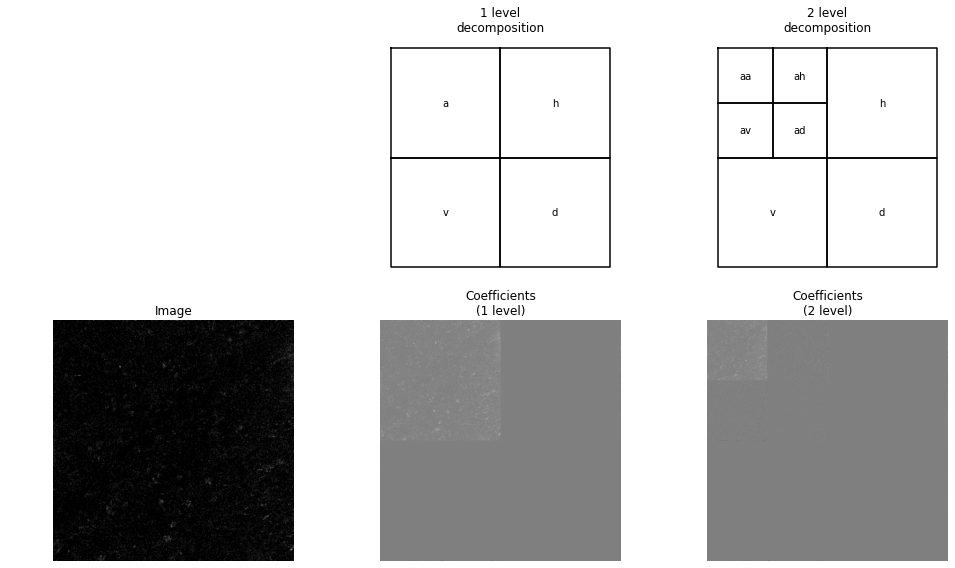

In [10]:
plot_wavelet_decomp(img)

In [11]:
a1,(h1,v1,d1) = pywt.wavedec2(img, 'sym2', mode='periodization', level=1)
aa,(ah,av,ad),(h2,v2,d2) = pywt.wavedec2(img, 'sym2', mode='periodization', level=2)

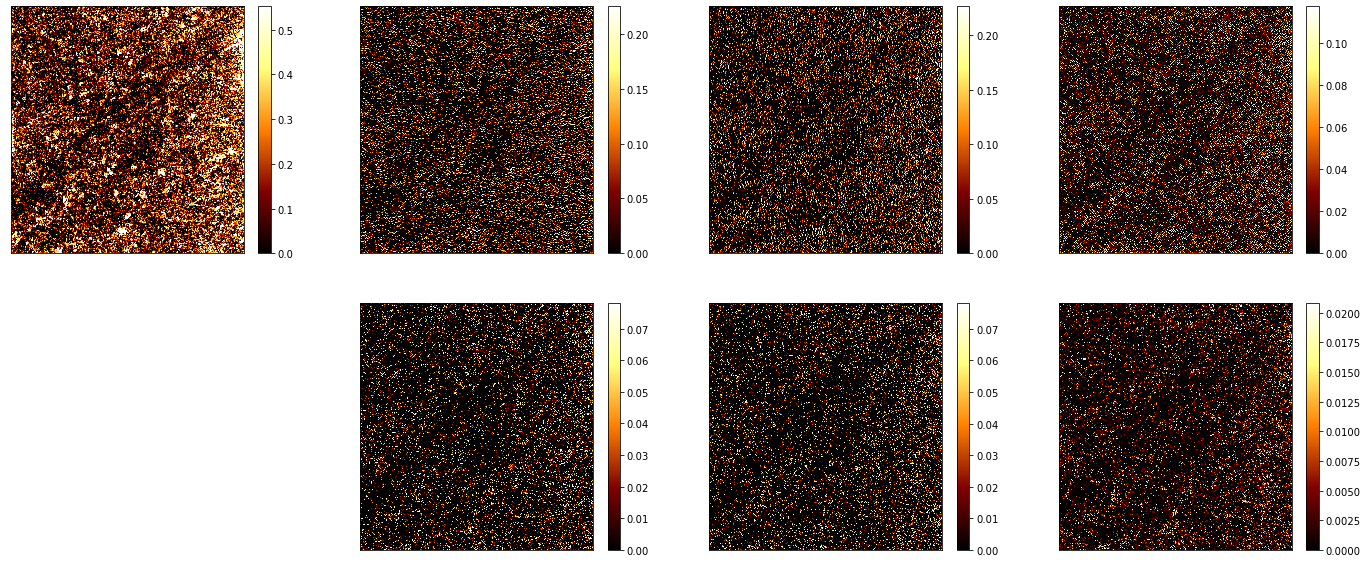

In [23]:
wavelet = 'sym2'
#wavelet = 'bior3.5'
aa,(ah,av,ad),(h2,v2,d2) = pywt.wavedec2(img, wavelet, mode='periodization', level=2)
nrows = 2
ncols = 4
fig = plt.figure(figsize=(ncols*6, nrows*5))

for k,wimg in enumerate([aa, ah, av, ad]):
    ax = plt.subplot(nrows, ncols, k+1)
    plot_img(wimg, transform=False, saturate_percentile=95)
    
    
for k,wimg in enumerate([h2, v2, d2]):
    ax = plt.subplot(nrows, ncols, ncols + k + 1 + 1)
    plot_img(wimg, transform=False, saturate_percentile=95)

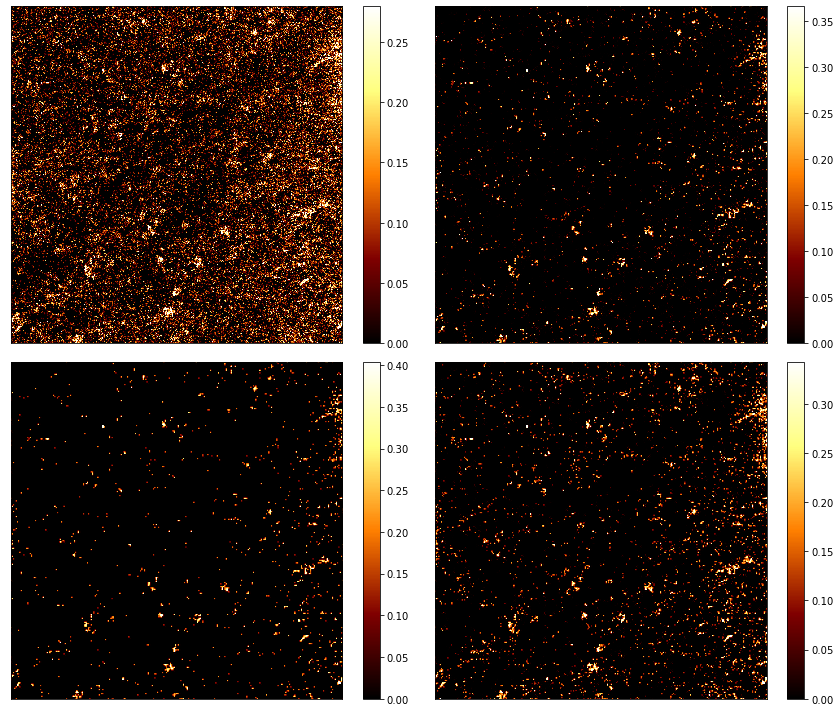

In [40]:
thresholds = [[0.65, 0.25, 0.25, 0.12, 0.10, 0.10, 0.03],
              [0.65, 100, 100, 100, 100, 100, 100],
              [0.5, 0.25, 0.25, 0.12, 100, 100, 100]]

img_denoised_wavelet = list()
for thresh in thresholds:
    coefs = list()
    for k,wimg in enumerate([aa, ah, av, ad, h1, v1, d1]):
        wt = wimg.copy()
        wt[wt < thresh[k]] = 0
        coefs.append(wt)

    coefs = [coefs[0], (coefs[1], coefs[2], coefs[3]),
     (coefs[4], coefs[5], coefs[6])]

    wt_rec = pywt.waverec2(coefs, wavelet, mode='periodization')
    img_denoised_wavelet.append(wt_rec)

nrows = 2
ncols = 2

fig = plt.figure(figsize=(ncols*6, nrows*5))

ax = plt.subplot(nrows, ncols, 1)
plot_img(img, transform=False, saturate_percentile=99)
plt.autoscale(tight=True)

for k,img_w in enumerate(img_denoised_wavelet):
    ax = plt.subplot(nrows, ncols, k+2)
    plot_img(img_w, transform=False, saturate_percentile=99)
    plt.autoscale(tight=True)

plt.tight_layout()

# BM3D

In [14]:
import bm3d
sigmas = [0.01, 0.1, 0.5]
img_denoised = dict()
for sig in sigmas:
    img_denoised[sig] = bm3d.bm3d(img, sigma_psd=sig, stage_arg=bm3d.BM3DStages.ALL_STAGES)

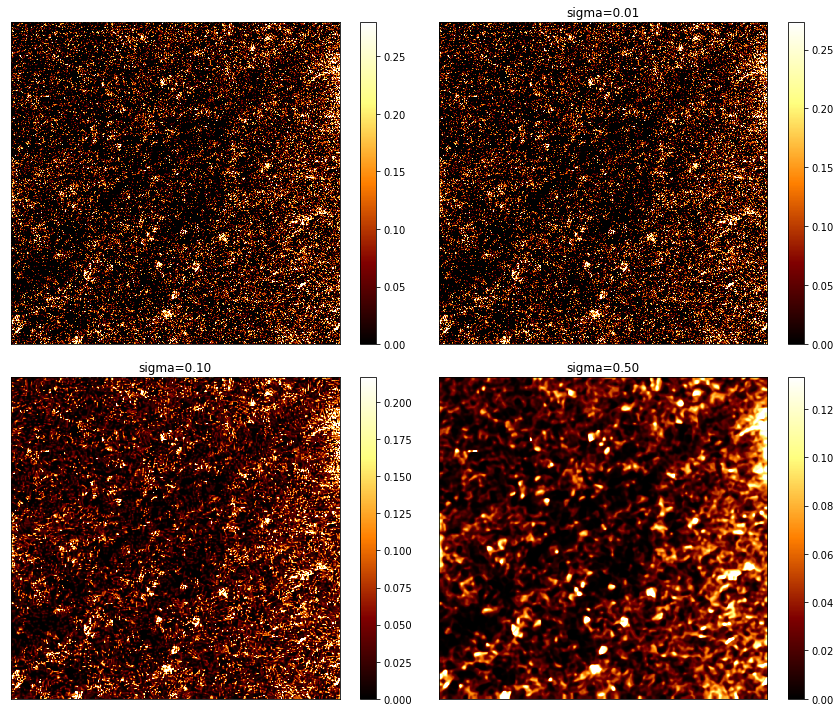

In [15]:
nrows = 2
ncols = 2

fig = plt.figure(figsize=(ncols*6, nrows*5))

ax = plt.subplot(nrows, ncols, 1)
plot_img(img, transform=False, saturate_percentile=99)

for k,sig in enumerate(sigmas):
    ax = plt.subplot(nrows, ncols, k+2)
    plot_img(img_denoised[sig], transform=False, saturate_percentile=99)
    plt.title(f"sigma={sig:.2f}")
    plt.autoscale(tight=True)
plt.tight_layout()

# KNN Denoising

In [16]:
from mibi.preprocess.knn_denoise import _remove_noise, _mean_knn_dist
nz, knn_mean_dist = _mean_knn_dist(img)
knn_mean_dist.shape

(919471,)

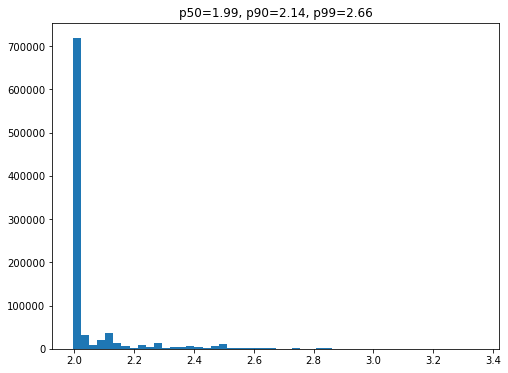

In [17]:
fig = plt.figure(figsize=(8, 6))
percentiles = np.arange(1, 100)
per_vals = np.percentile(knn_mean_dist, percentiles)
t = f"p50={per_vals[49]:.2f}, p90={per_vals[89]:.2f}, p99={per_vals[98]:.2f}"
plt.hist(knn_mean_dist, bins=50)
plt.title(t);

In [18]:
knn_thresholds = [per_vals[40], per_vals[90]]
knn_denoised = list()
for thresh in knn_thresholds:
    knn_denoised.append(_remove_noise(nz, knn_mean_dist, img, thresh))

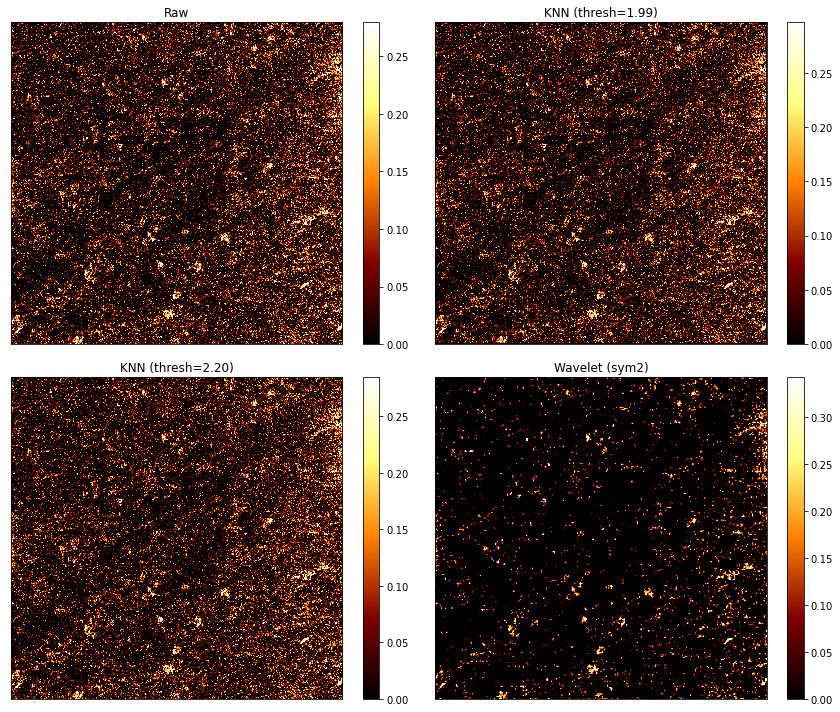

In [41]:
nrows = 2
ncols = 2

fig = plt.figure(figsize=(ncols*6, nrows*5))

ax = plt.subplot(nrows, ncols, 1)
plot_img(img, transform=False, saturate_percentile=99)
plt.title('Raw')
plt.autoscale(tight=True)

for k,kimg in enumerate(knn_denoised):
    ax = plt.subplot(nrows, ncols, k+2)
    plot_img(kimg, transform=False, saturate_percentile=99)
    plt.title(f"KNN (thresh={knn_thresholds[k]:0.2f})")
    plt.autoscale(tight=True)
    
ax = plt.subplot(nrows, ncols, 4)
plot_img(img_denoised_wavelet[-1], transform=False, saturate_percentile=99)
plt.title(f'Wavelet ({wavelet})')
plt.autoscale(tight=True)

plt.tight_layout()

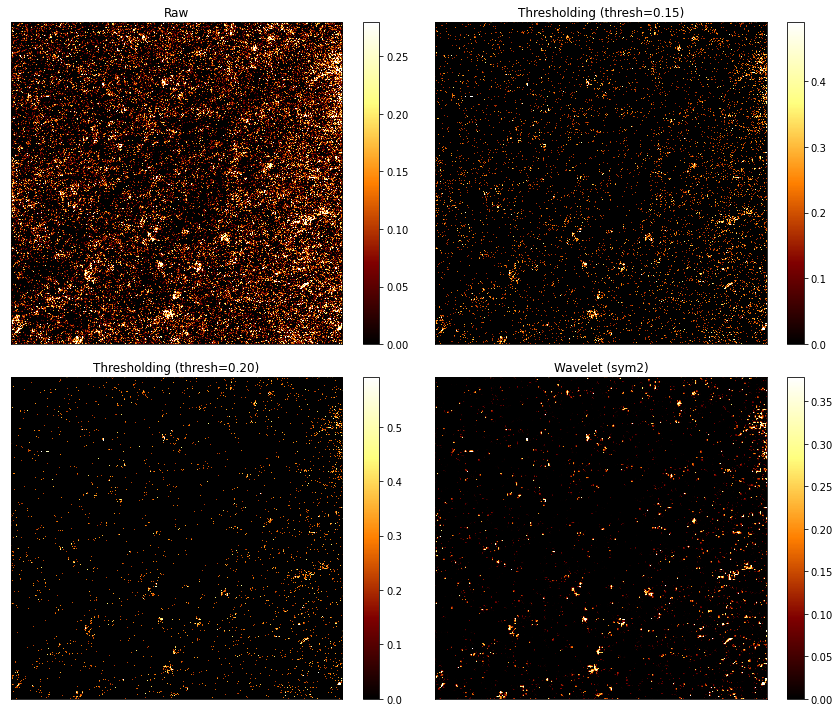

In [21]:
simple_thresh = list()
thresholds = [0.15, 0.20]
for thresh in thresholds:
    timg = img.copy()
    timg[timg < thresh] = 0.
    simple_thresh.append(timg)
    
nrows = 2
ncols = 2

fig = plt.figure(figsize=(ncols*6, nrows*5))

ax = plt.subplot(nrows, ncols, 1)
plot_img(img, transform=False, saturate_percentile=99)
plt.title('Raw')
plt.autoscale(tight=True)

for k,timg in enumerate(simple_thresh):
    ax = plt.subplot(nrows, ncols, k+2)
    plot_img(timg, transform=False, saturate_percentile=99)
    plt.title(f"Thresholding (thresh={thresholds[k]:0.2f})")
    plt.autoscale(tight=True)

ax = plt.subplot(nrows, ncols, 4)
plot_img(img_denoised_wavelet, transform=False, saturate_percentile=99)
plt.title(f'Wavelet ({wavelet})')
plt.autoscale(tight=True)

plt.tight_layout()